In [26]:
cd /home

/home


In [27]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import pandas as pd
import numpy as np
import toml
import wandb
import toml
import glob
import os

from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from src.models.astromer_2 import restore_model, predict
from src.utils import get_metrics, plot_cm
from src.data.loaders import get_loader
from src.training.utils import train
from matplotlib import gridspec


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2
os.environ["CUDA_VISIBLE_DEVICES"]="3"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
folder = './presentation/experiments/astromer_2/results/'
exp_folders = glob.glob(os.path.join(folder, '*', '*', 'pretraining'))
exp_folders = [exp_folders[0]]
exp_folders

['./presentation/experiments/astromer_2/results/clean_ckpt/2023-11-08_22-13-40/pretraining']

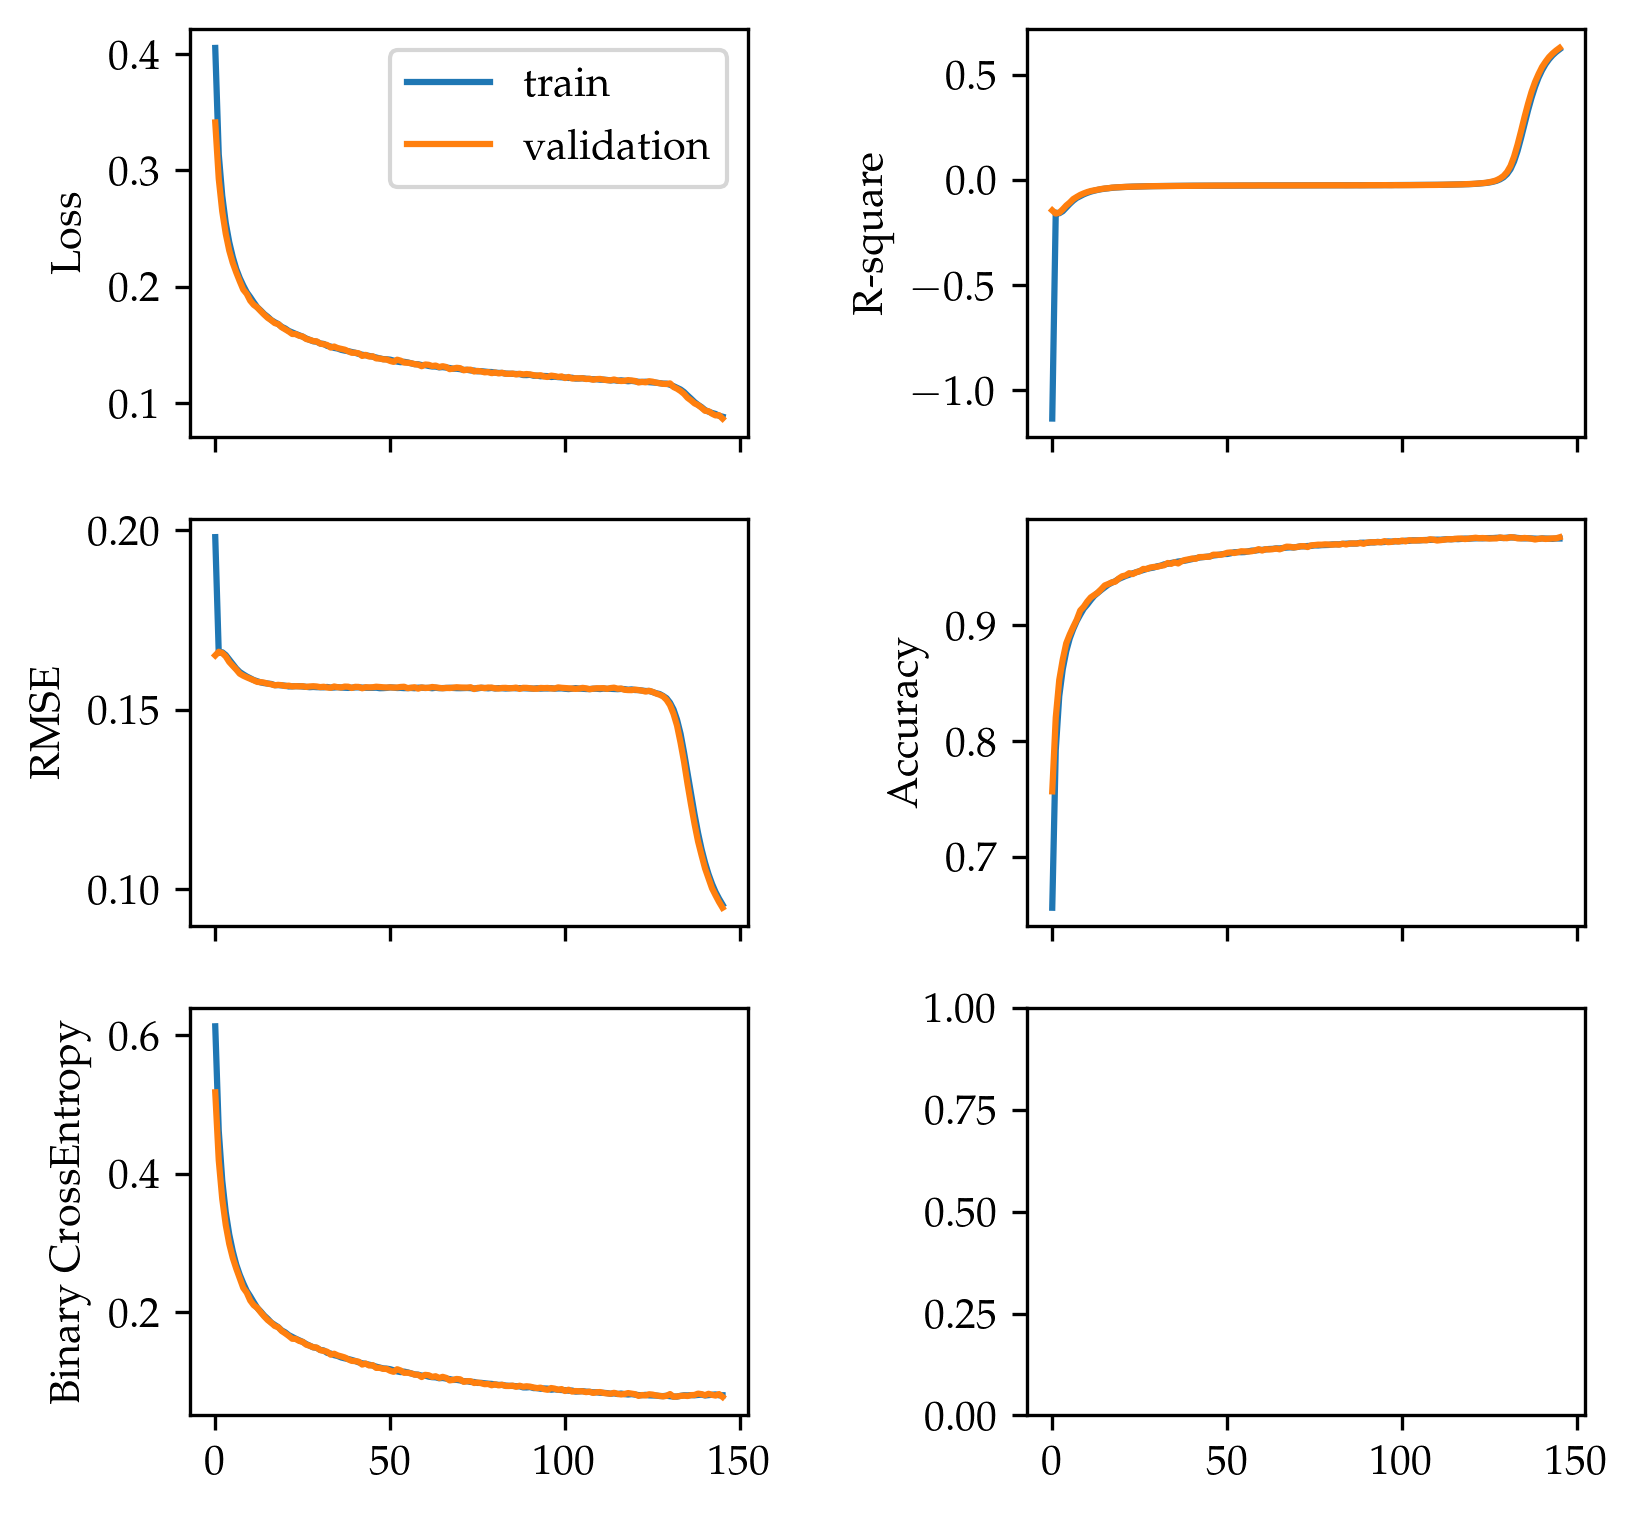

In [60]:
metric_names= ['epoch_loss', 'epoch_r_square', 'epoch_rmse', 'epoch_acc', 'epoch_bce']
format_metric_name = {
    'epoch_loss':'Loss',
    'epoch_r_square': 'R-square',
    'epoch_rmse': 'RMSE',
    'epoch_acc': 'Accuracy',
    'epoch_bce':'Binary CrossEntropy'
}

rows = []
fig, axes = plt.subplots(3, 2, figsize=(6, 6), sharex=True, gridspec_kw={'wspace':0.5}, dpi=300)
axes = axes.flatten()
for expdir in exp_folders:
    config_path = os.path.join(expdir, 'config.toml')
    log_dir = os.path.join(expdir, 'tensorboard')
    
    with open(config_path, 'r') as f:
        config = toml.load(f)

        val_metrics = get_metrics(os.path.join(log_dir, 'validation'), 
                                  metric_name='epoch_loss', show_keys=False)
        best_epoch = val_metrics['value'].astype(float).argmin() 

        for index, metric in enumerate(metric_names):
            try:
                train_metrics = get_metrics(os.path.join(log_dir, 'train'), metric_name=metric, show_keys=False)
                valid_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name=metric)

                axes[index].plot(train_metrics['step'], train_metrics['value'], label='train')
                axes[index].plot(valid_metrics['step'], valid_metrics['value'], label='validation')
                try:
                    test_metrics = get_metrics(os.path.join(log_dir, 'test'), metric_name=metric)
                    axes[index].plot([0, valid_metrics['step'].iloc[-1]], 
                                     test_metrics['value'], label='test', 
                                     linestyle='--', linewidth=1)

                    
                except:
                    pass
                axes[index].set_ylabel(format_metric_name[metric])
                config[metric] = np.round(train_metrics.iloc[best_epoch]['value'], 3)
                config[metric+'_val'] = np.round(valid_metrics.iloc[best_epoch]['value'], 3)        
            except Exception as e:
                print(e)
                continue
                
        rows.append(pd.Series(config))
axes[0].legend()
results = pd.concat(rows, axis=1).T

# Reconstruction

In [6]:
config_path = './presentation/experiments/astromer_2/results/astromer_2_clean/2023-11-02_20-32-34/pretraining/' 

astromer, conf = restore_model(config_path)

[INFO] NSP Encoder
[INFO] LOADING PRETRAINED WEIGHTS


In [14]:
test_loader = get_loader(dataset='./data/records/macho_clean/test/', 
                         batch_size= 2000, 
                         window_size=conf['window_size'], 
                         probed_frac=0.,  
                         random_frac=0.,
                         nsp_prob=0.8,
                         repeat=1, 
                         sampling=False)

[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] NSP format activated


In [15]:
%%time
y_pred, y_true, mask, cls_pred, cls_true = predict(astromer, test_loader)

[INFO] Processing 115 batches


100%|███████████████████████████████████████████████████████████████████████████████| 115/115 [00:29<00:00,  3.85it/s]


CPU times: user 6min 24s, sys: 1min 15s, total: 7min 40s
Wall time: 40.9 s


In [16]:
cls_true_ = tf.squeeze(cls_true)
cls_pred_ = tf.squeeze(tf.argmax(cls_pred, 2))
cm = confusion_matrix(cls_true_, cls_pred_, normalize='true')

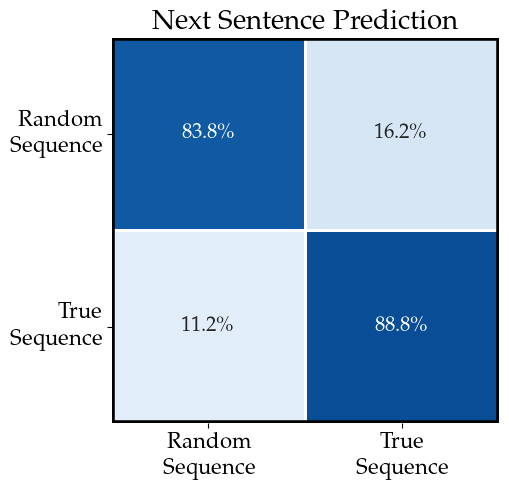

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
class_names = ['Random\n Sequence', 'True\n Sequence']
plot_cm(cm, ax=ax, title='Next Sentence Prediction', class_names=class_names)
plt.show()

Text(0.96, 0.5, 'Predicted Magnitude')

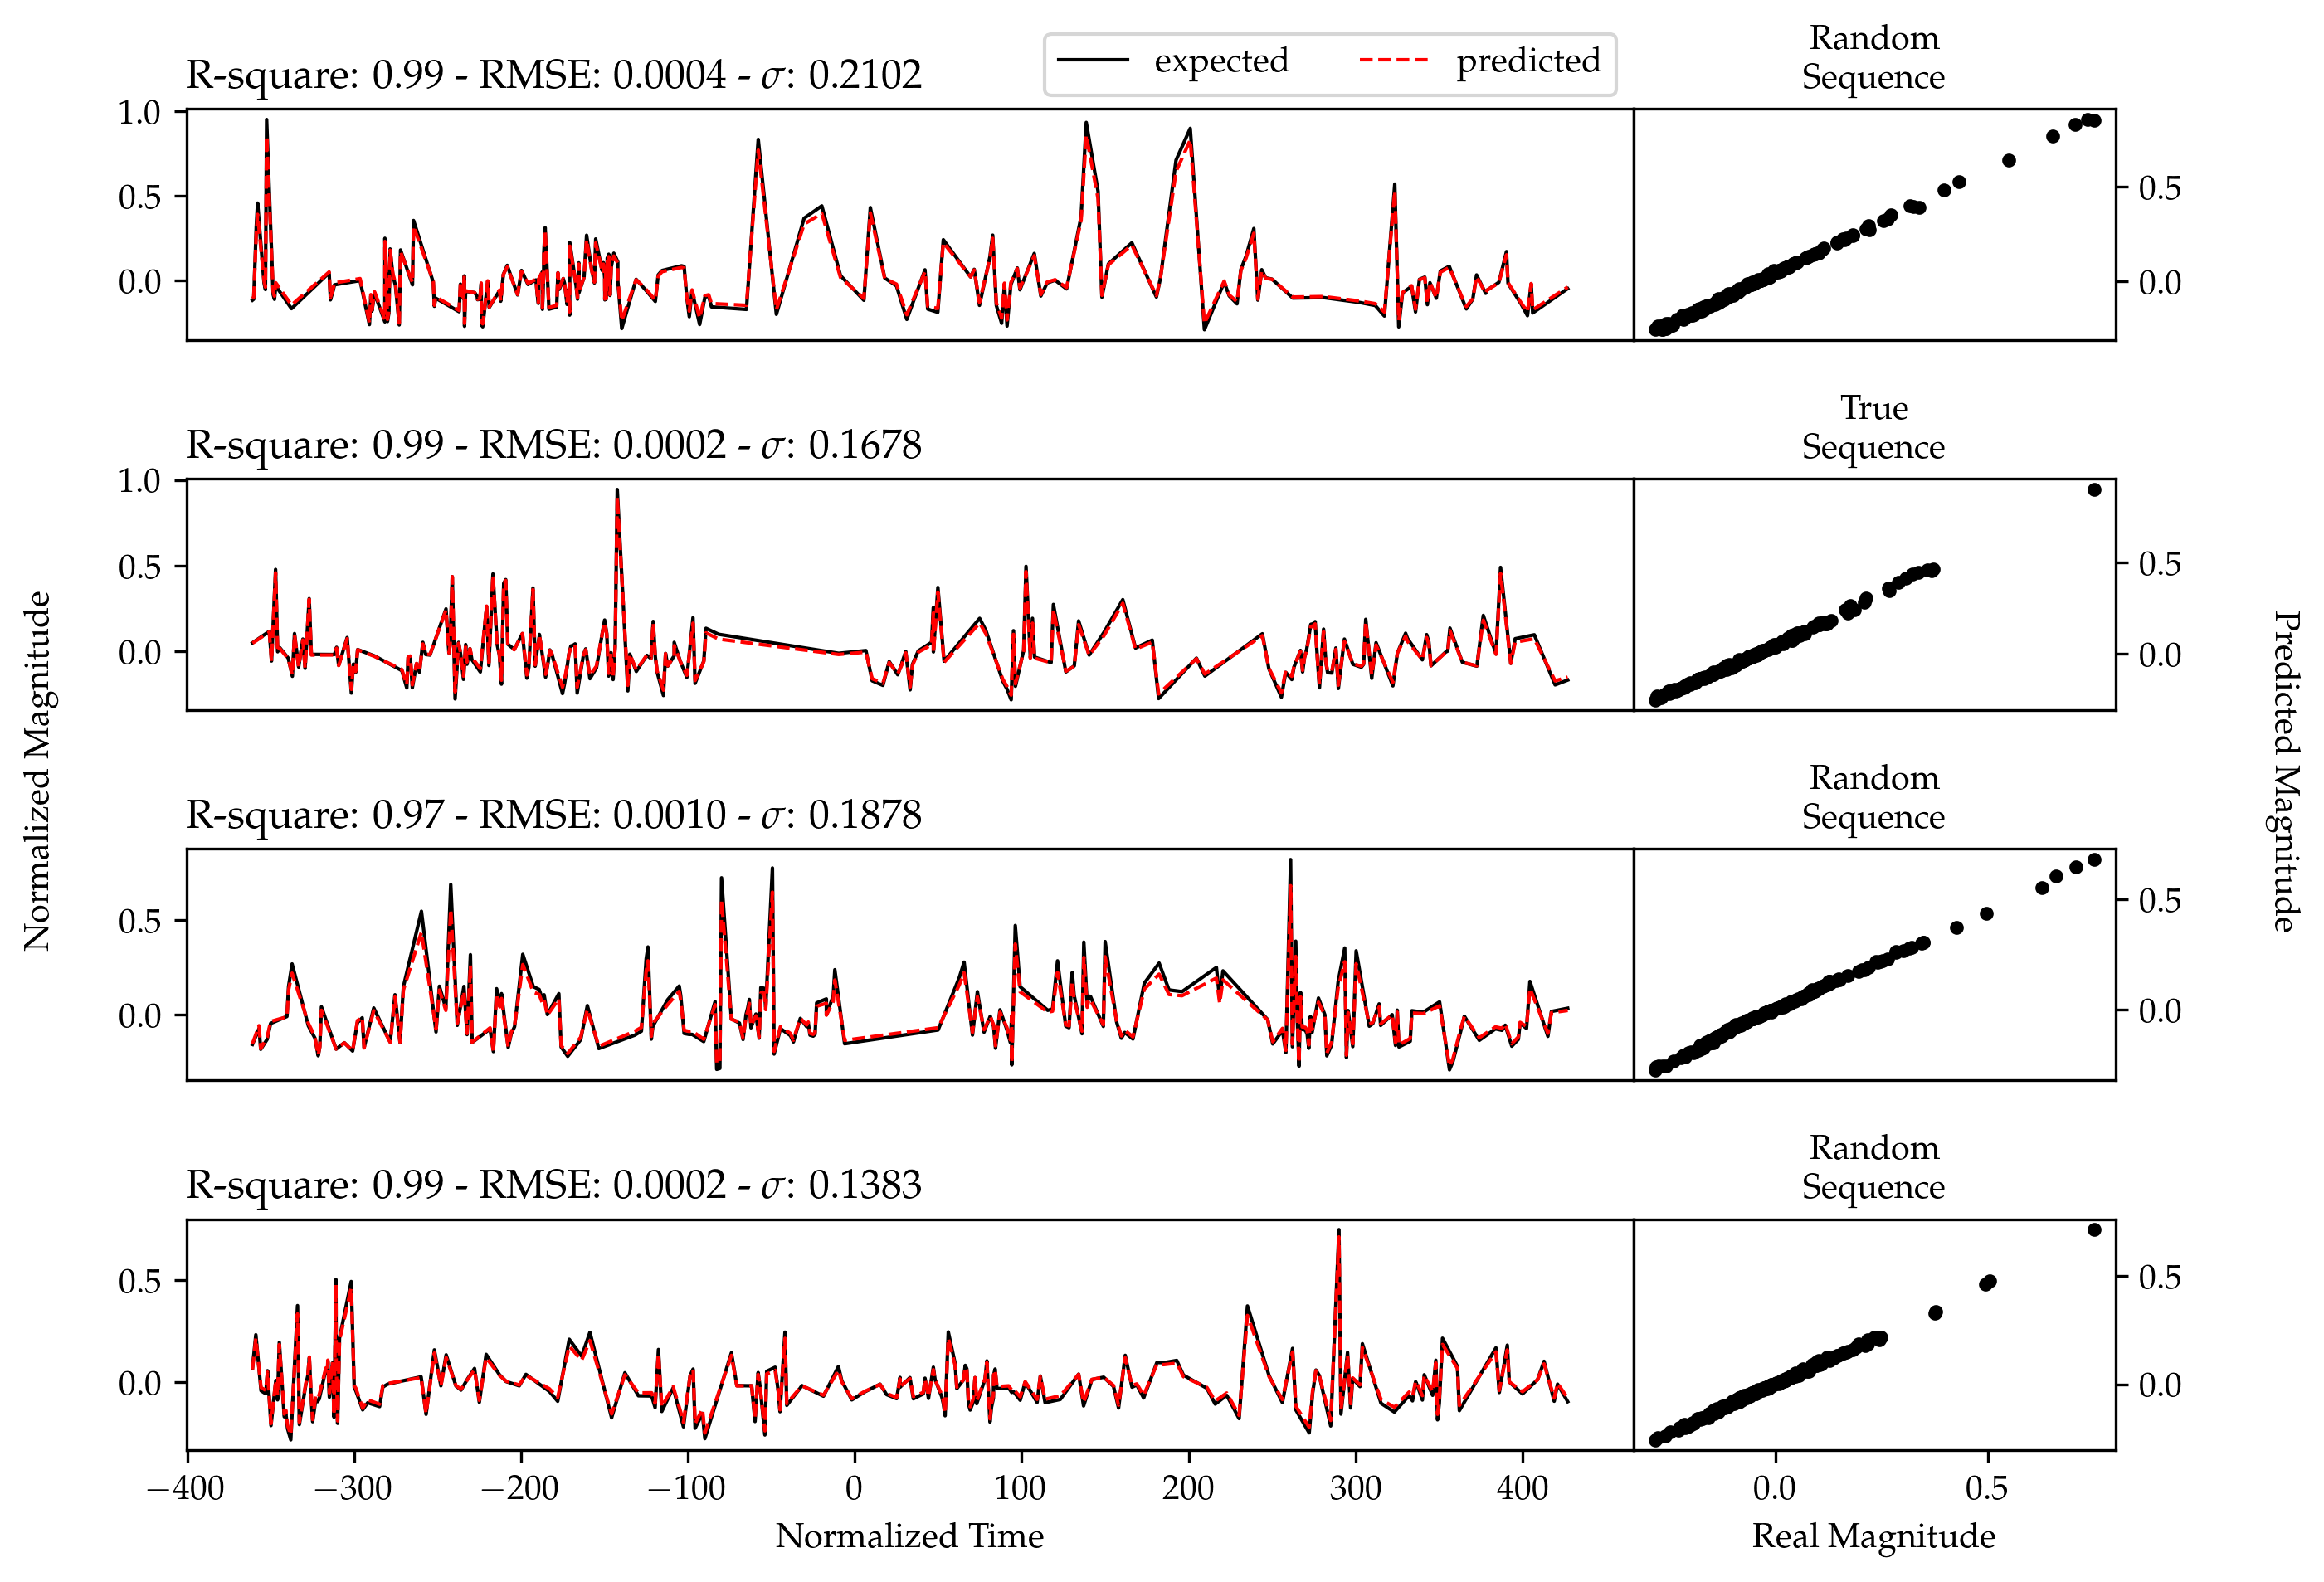

In [18]:
N = 4                  
fig = plt.figure(figsize=(10,7), dpi=300)
gs = gridspec.GridSpec(N, 2, width_ratios=[3, 1]) 
gs.hspace = 0.6
gs.wspace = 0.
# plt.subplots_adjust(hspace=0.2, wspace=0.05)

for i, x, y, m, clst, clsp in zip(range(N), y_true, y_pred, mask, cls_true_, cls_pred_):
    ax0 = plt.subplot(gs[i, 0])
    ax1 = plt.subplot(gs[i, 1])
    
    probed_true  = tf.boolean_mask(x, m[..., 0])
    probed_pred  = tf.boolean_mask(y, m[..., 0])
    
    r2_val   = r2_score(probed_true[:, 1], probed_pred[:, 1])
    rmse_val = mean_squared_error(probed_true[:, 1], probed_pred[:, 1], squared=True)
    
    ax0.plot(probed_true[:, 0], probed_true[:, 1], marker='', linewidth=1, linestyle='-', color='k', label='expected')
    ax0.plot(probed_pred[:, 0], probed_pred[:, 1], marker='', linewidth=1, linestyle='--', color='r', label='predicted')
    ax1.plot(probed_true[:, 1], probed_pred[:, 1], '.', color='k')
    ax0.set_title('R-square: {:.2f} - RMSE: {:.4f} - $\sigma$: {:.4f}'.format(r2_val, 
                                                                          rmse_val, 
                                                                          tf.math.reduce_std(probed_true[:, 1])), 
                                                                         loc='left')
    
    ax1.set_title('{}'.format(class_names[int(clst)]), fontsize=10)
    if i< N-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax1.set_xticks([])
        
    ax1.yaxis.tick_right() 

    if i ==0:
        ax0.legend(ncol=3,bbox_to_anchor=(1, 1.4))
        
ax0.set_xlabel('Normalized Time')
ax1.set_xlabel('Real Magnitude')
fig.text(0.06, 0.5, 'Normalized Magnitude', va='center', rotation='vertical')
fig.text(0.96, 0.5, 'Predicted Magnitude', va='center', rotation=-90)